# Using the exponentially weighted covarince in an Equal Risk Contribution portfolio optimisation problem

The Equal Risk Contribution (ERC) portfolio seeks to maximally diversify portfolio risk by equalising the risk contribution of each component. 

The intuition is as follows:
- Imagine we have a 3-asset portfolio
- Assets 1 and 2 are perfectly correlated (correlation of 1.0)
- Asset 3 is uncorrelated with the other two (correlation of 0.0)

Let's say we equal-weighted the three assets. We'd have 33% in asset 1, 33% in asset 2, and 33% in asset 3. But since assets 1 and 2 are perfectly correlated, from a risk perspective, this is like having 66% in a single asset and 33% in another (if we assume the variances are equal). 

The ERC approach recognises that assets 1 and 2 are essentially two versions of the same thing, and would therefore down-weight these assets, and up-weight asset 3 until the risk contribution of each asset was equal. The actual weights would depend upon the variances of the individual assets, and their pairwise covariances. 

Note that this optimisation doesn't depend on expected returns - it only seeks to maximally diversify risk. This might make it a useful framework for strategies where you don't have a view on which assets you expect to outperform, but where managing risk matters, for instance risk premia harvesting portfolios. 

[Here's the original ERC paper](http://www.thierry-roncalli.com/download/erc.pdf) if you'd like to read more. 

The ERC optimisation depends on your estimate of covariance between the assets in the portfolio, and the optimisation is only as good as your estimate of future covariance.  

We know from previous work that covariance is noisily [autocorrelated](https://robotwealth.com/using-exponentially-weighted-moving-averages-to-navigate-trade-offs-in-systematic-trading/). We also [saw](https://robotwealth.com/an-expenonetially-weighted-covariance-matrix-in-r/) that an exponentially weighted measurement of past covariance may have some advantages over a rolling window estimate. It's my working hypothesis that using an exponentially weighted covariance estimate should give ERC portfolios a small boost, since they do a marginally better job of estimating future covariance. 

Let's see if there's anything to this idea. 

We'll create a daily-updating ERC portfolio using a reasonably diversified portfolio of liquid ETFs:
- TLT: long duration US government bonds
- SPY: US stocks
- GLD: gold
- VWO: emerging market stocks
- EMB: emerging market bonds

And we'll see if an exponentially weighted covariance estimate leads to a better performing ERC portfolio.


An optimisation routine that figures out the ERC weights given a covariance matrix is implemented in the `PERC` function of R's `FRAPO` (Financial Risk Modelling and Portfolio Optimisation) package. We'll use it to calculate our ERC weights. 

We'll source some helper functions rather than include them in this notebook. I'll include them below so that you can reproduce this if you want to.

In [80]:
library(FRAPO)
library(tidyverse)
library(roll)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7, warn=-1)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

# source helper functions
source("erc_helpers.R")

Get some data from Yahoo Finance and calculate returns. 

In [69]:
# get data
tickers <- c("TLT", "SPY", "GLD", "VWO", "EMB")
prices <- yahoo_prices(
    tickers,
    from_date = "2008-01-01",
    to_date = "2023-11-16"
  ) %>% 
  arrange(Date, Ticker)
 
head(prices)

,Date,Ticker,Open,High,Low,Close,Adj.Close,Volume
,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,2007-12-31,EMB,101.37,101.40,101.35,101.35,47.42955,1600
2,2007-12-31,GLD,82.74,82.83,81.98,82.46,82.46000,3815600
3,2007-12-31,SPY,147.10,147.61,146.06,146.21,107.71794,108126800
4,2007-12-31,TLT,92.78,93.28,92.60,93.04,59.36024,1647600
5,2007-12-31,VWO,53.09,53.24,52.15,52.15,34.10643,1039000
6,2008-01-02,EMB,101.15,101.53,101.15,101.49,47.49503,7600


In [86]:
# we'll need simple and log returns
returns <- prices %>%
  select(Ticker, Date, Adj.Close) %>%
  arrange(Date) %>%
  group_by(Ticker) %>%
  mutate(
    simple_return = (Adj.Close - dplyr::lag(Adj.Close))/dplyr::lag(Adj.Close),
    fwd_simple_return = dplyr::lead(simple_return),
    log_return = log(Adj.Close/dplyr::lag(Adj.Close)),
    fwd_log_return = dplyr::lead(log_return)
  )

# make wide returns dataframe
wide_rets <- returns %>%
  select(Ticker, Date, log_return) %>%
  pivot_wider(Date, names_from = Ticker, values_from = log_return) %>%
  na.omit()

# make pairwise returns dataframe 
pairwise_returns <- returns %>%
  full_join(returns, by = "Date") %>%
  ungroup() %>% 
  # get all combinations (tickers) and remove duplicate combos (eg A-AA, AA-A)
  mutate(tickers = ifelse(Ticker.x < Ticker.y, glue("{Ticker.x}, {Ticker.y}"), glue("{Ticker.y}, {Ticker.x}"))) %>%
  distinct(Date, tickers, .keep_all = TRUE) %>%
  # arrange for rolling pairwise ewma correlations
  arrange(Date, .by_group = TRUE) %>%
  na.omit() 

head(pairwise_returns)

Ticker.x,Date,Adj.Close.x,simple_return.x,fwd_simple_return.x,log_return.x,fwd_log_return.x,Ticker.y,Adj.Close.y,simple_return.y,fwd_simple_return.y,log_return.y,fwd_log_return.y,tickers
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
EMB,2008-01-02,47.49503,0.001380553,0.001773975,0.001379601,0.001772403,EMB,47.49503,0.001380553,0.0017739750,0.001379601,0.0017724033,"EMB, EMB"
EMB,2008-01-02,47.49503,0.001380553,0.001773975,0.001379601,0.001772403,GLD,84.86000,0.029105045,0.0083667098,0.028689536,0.0083319029,"EMB, GLD"
EMB,2008-01-02,47.49503,0.001380553,0.001773975,0.001379601,0.001772403,SPY,106.77493,-0.008754419,-0.0004828099,-0.008792964,-0.0004829265,"EMB, SPY"
EMB,2008-01-02,47.49503,0.001380553,0.001773975,0.001379601,0.001772403,TLT,60.21521,0.014403125,-0.0013782065,0.014300386,-0.0013791571,"EMB, TLT"
EMB,2008-01-02,47.49503,0.001380553,0.001773975,0.001379601,0.001772403,VWO,34.00834,-0.002875910,0.0096153770,-0.002880053,0.0095694435,"EMB, VWO"
GLD,2008-01-02,84.86000,0.029105045,0.008366710,0.028689536,0.008331903,GLD,84.86000,0.029105045,0.0083667098,0.028689536,0.0083319029,"GLD, GLD"


Next, we calculate exponentially weighted covariances for each pair of assets in the portfolio, for each day. 

From that, we recover the covariance matrix each day, pass it to `FRAPO::PERC` and get the next day's ERC weights. 

This will take a while, as we calculate a new set of weights each day based on the updated covariance matrix:

In [82]:
# wrangle ewma covariances
lambda <- 0.99
wdw <- 200  # a reasonable approximation of an "equivalent" window length is 2/(1-lambda)
ewma_covs <- pairwise_returns %>%
  group_by(tickers) %>%
  arrange(Date, .by_group = TRUE) %>%
  mutate(cov = ewma_cov(log_return.x, log_return.y, lambda = lambda, initialisation_wdw = wdw)) %>%
  select(Date, tickers, cov) %>%
  na.omit()

ewma_covs_long <- ewma_covs %>%
  separate(tickers, into = c("ticker.x", "ticker.y")) 

# daily ERC weights from exponentially weighted covariance matrix
days <- ewma_covs_long %>% distinct(Date) %>% pull()
tickers <- ewma_covs_long %>% distinct(ticker.x) %>% pull()
num_assets <- length(tickers)

erc_wgts <- vector(mode = "list", length = length(days))
non_psd <- vector(mode = "numeric", length = length(days))
i <- 1
for(day in days) {
  
  cov_mat <- ewma_covs_long %>%
    dplyr::filter(Date == day) %>%
    recover_covmat(tickers, num_assets)

  # check that covmat is PSD, if not convert to nearest
  if(any(round(eigen(cov_mat)$values, 10) < 0)) {
    capture.output(psd <- Matrix::nearPD(cov_mat, keepDiag = TRUE, ensureSymmetry = TRUE, base.matrix = TRUE, maxit = 100), file = "NULL", type = "message")
    cov_mat <- psd$mat
    # if still non-psd or non symmetrical (eg due to non-convergence of nearPD), use hacky method
    if(any(round(eigen(cov_mat)$values, 10) < 0) || !isSymmetric(cov_mat)) {
      cov_mat <- get_near_psd(cov_mat)
      # sometimes this will still fail as we force symmetry - just note this for now
      if(any(round(eigen(cov_mat)$values, 10) < 0)) {
        non_psd[[i]] <- day
      }
    }
  }

  # ERC weights based on covariance matrix 
  capture.output(these_wgts <- FRAPO::PERC(Sigma = cov_mat), file = "NULL")  # too much output...
  erc_wgts[[i]] <- Weights(these_wgts) 
  i <- i + 1
}

erc_wgts <- wrangle_weights(erc_wgts, dates = ewma_covs_long %>% distinct(Date) %>% arrange(Date), tickers)

Let's see how this approach performed (not considering costs):

Ann.Return,Ann.Vol,Ann.Sharpe
<dbl>,<dbl>,<dbl>
0.07102324,0.08523356,0.8332779


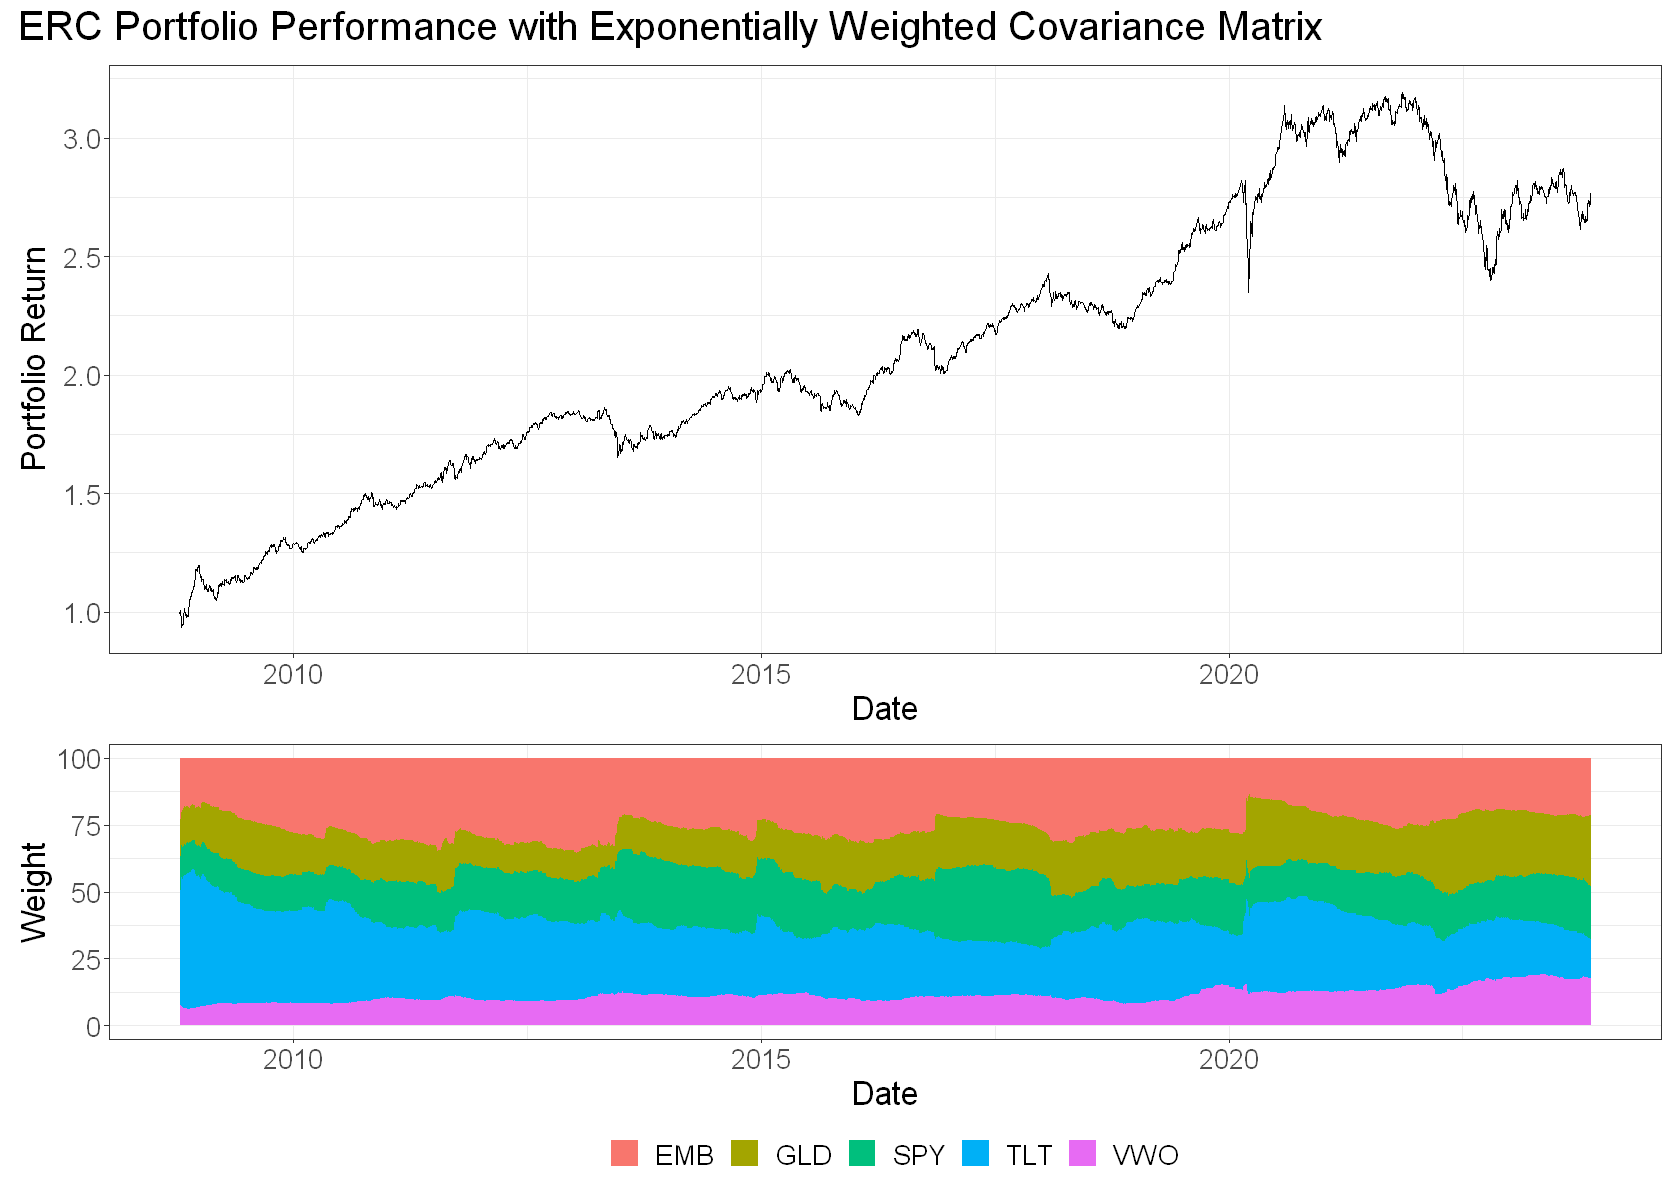

In [83]:
options(repr.plot.width = 14, repr.plot.height=10)
show_performance(erc_wgts, title = "ERC Portfolio Performance with Exponentially Weighted Covariance Matrix")

We get an average annual return of around 7.1% at an annualised volatility of 8.5% for a Sharpe of 0.83.

You can see in the weights plot how the ERC algorithm tilted our weights around as covariances evolved. 

How does this compare to using a rolling covariance estimate?

Ann.Return,Ann.Vol,Ann.Sharpe
<dbl>,<dbl>,<dbl>
0.06777231,0.08624455,0.7858156


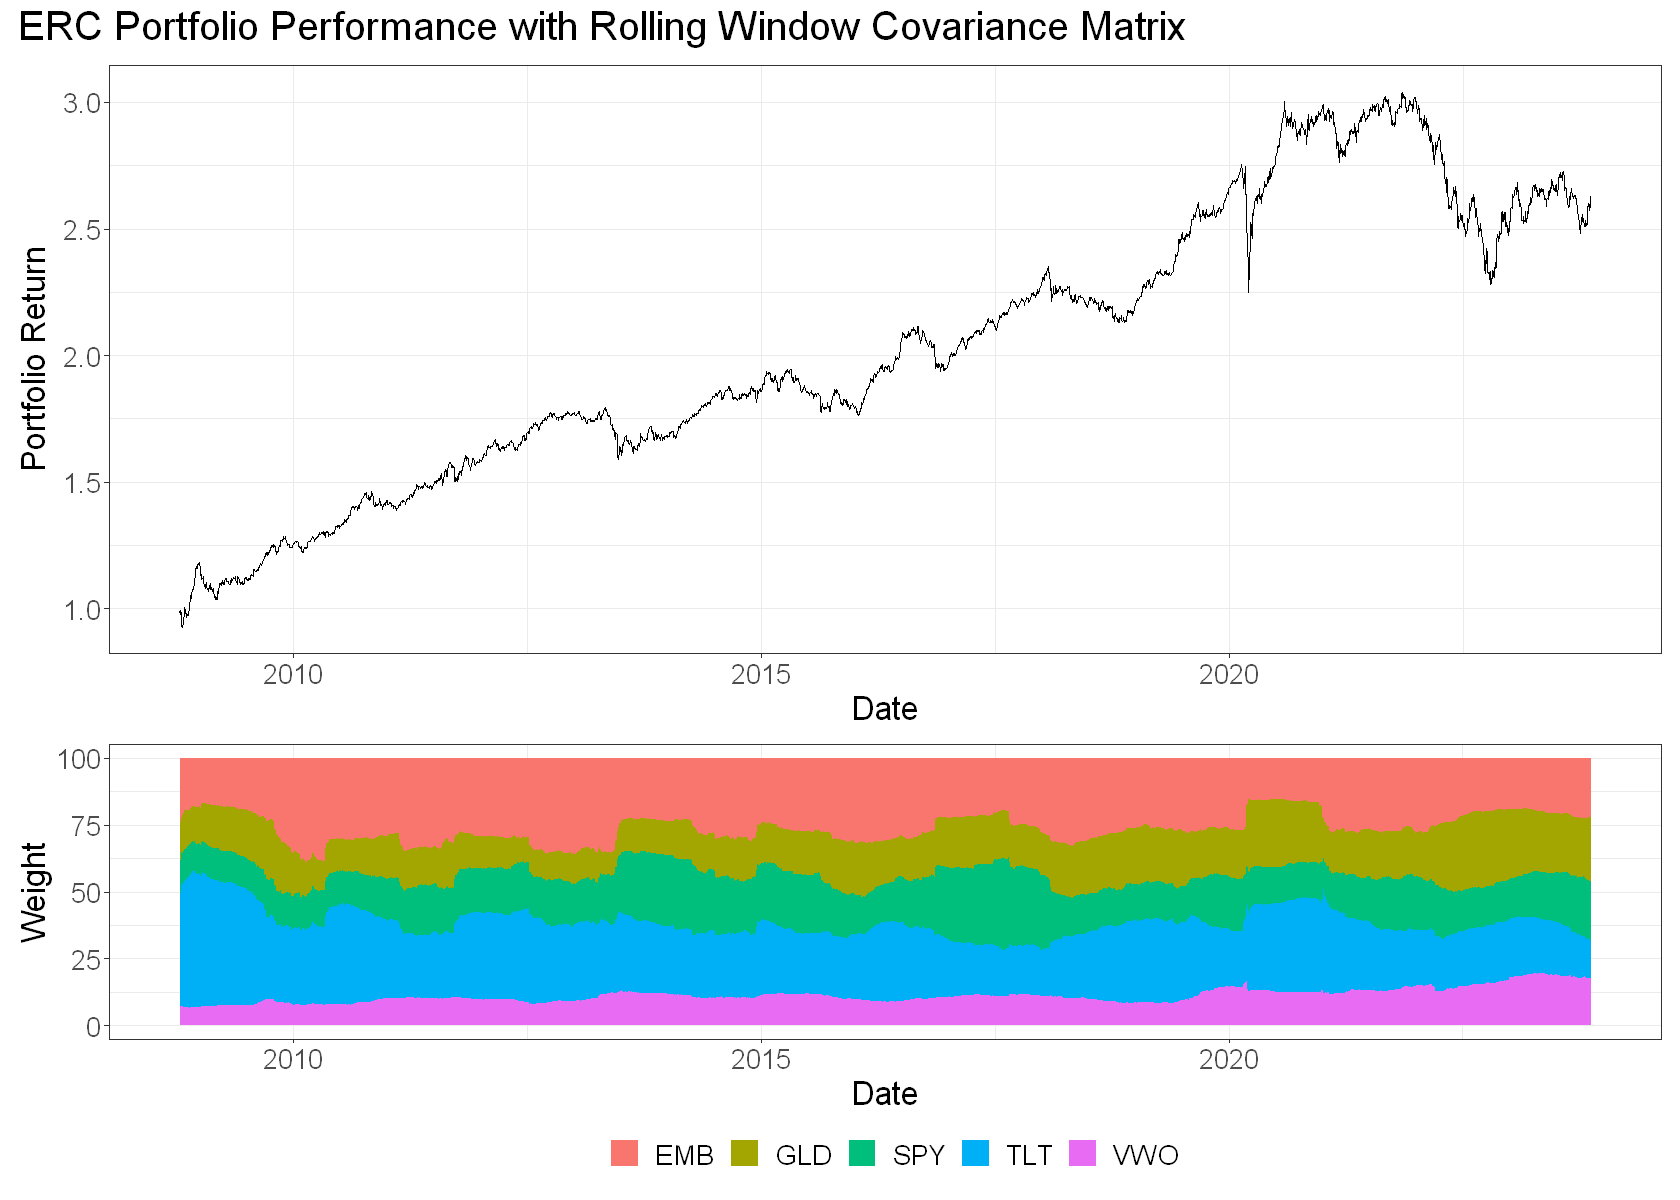

In [84]:
# calculate rolling pairwise covariances over period as a long dataframe
wdw = 200 # a reasonable approximation of an "equivalent" window length is 2/(1-lambda)
rolling_covs <- pairwise_returns %>%
  group_by(tickers) %>%
  arrange(Date, .by_group = TRUE) %>%
  mutate(cov = roll::roll_cov(  # replace with cov here, in previous function, and in previous use
    x = log_return.x, 
    y = log_return.y, 
    width = wdw
  )) %>% 
  select(Date, tickers, cov) %>%
  na.omit()

rolling_covs_long <- rolling_covs %>%
  separate(tickers, into = c("ticker.x", "ticker.y")) 

# daily ERC weights from exponentially weighted covariance matrix
days <- rolling_covs_long %>% distinct(Date) %>% pull()
tickers <- rolling_covs_long %>% distinct(ticker.x) %>% pull()
num_assets <- length(tickers)

erc_wgts <- vector(mode = "list", length = length(days))
non_psd <- vector(mode = "numeric", length = length(days))
i <- 1
for(day in days) {
  
  cov_mat <- rolling_covs_long %>%
    dplyr::filter(Date == day) %>%
    recover_covmat(tickers, num_assets)

  # check that covmat is PSD, if not convert to nearest
  if(any(round(eigen(cov_mat)$values, 10) < 0)) {
    capture.output(psd <- Matrix::nearPD(cov_mat, keepDiag = TRUE, ensureSymmetry = TRUE, base.matrix = TRUE, maxit = 100), file = "NULL", type = "message")
    cov_mat <- psd$mat
    # if still non-psd or non symmetrical (eg due to non-convergence of nearPD), use hacky method
    if(any(round(eigen(cov_mat)$values, 10) < 0) || !isSymmetric(cov_mat)) {
      cov_mat <- get_near_psd(cov_mat)
      # sometimes this will still fail as we force symmetry - just note this for now
      if(any(round(eigen(cov_mat)$values, 10) < 0)) {
        non_psd[[i]] <- day
      }
    }
  }

  # ERC weights based on covariance matrix 
  capture.output(these_wgts <- FRAPO::PERC(Sigma = cov_mat), file = "NULL")  # too much output...
  erc_wgts[[i]] <- Weights(these_wgts) 
  i <- i + 1
}

erc_wgts <- wrangle_weights(erc_wgts, dates = rolling_covs_long %>% distinct(Date) %>% arrange(Date), tickers)

show_performance(erc_wgts, title = "ERC Portfolio Performance with Rolling Window Covariance Matrix")

We get an annual return of 6.7% at an annualised volatility of 8.6% for a Sharpe of 0.79. So our exponentially weighted covariance gave a small improvement for not much additional effort. 

Compare to an equal weighted portfolio:

Ann.Return,Ann.Vol,Ann.Sharpe
<dbl>,<dbl>,<dbl>
0.1006095,0.184416,0.5455575


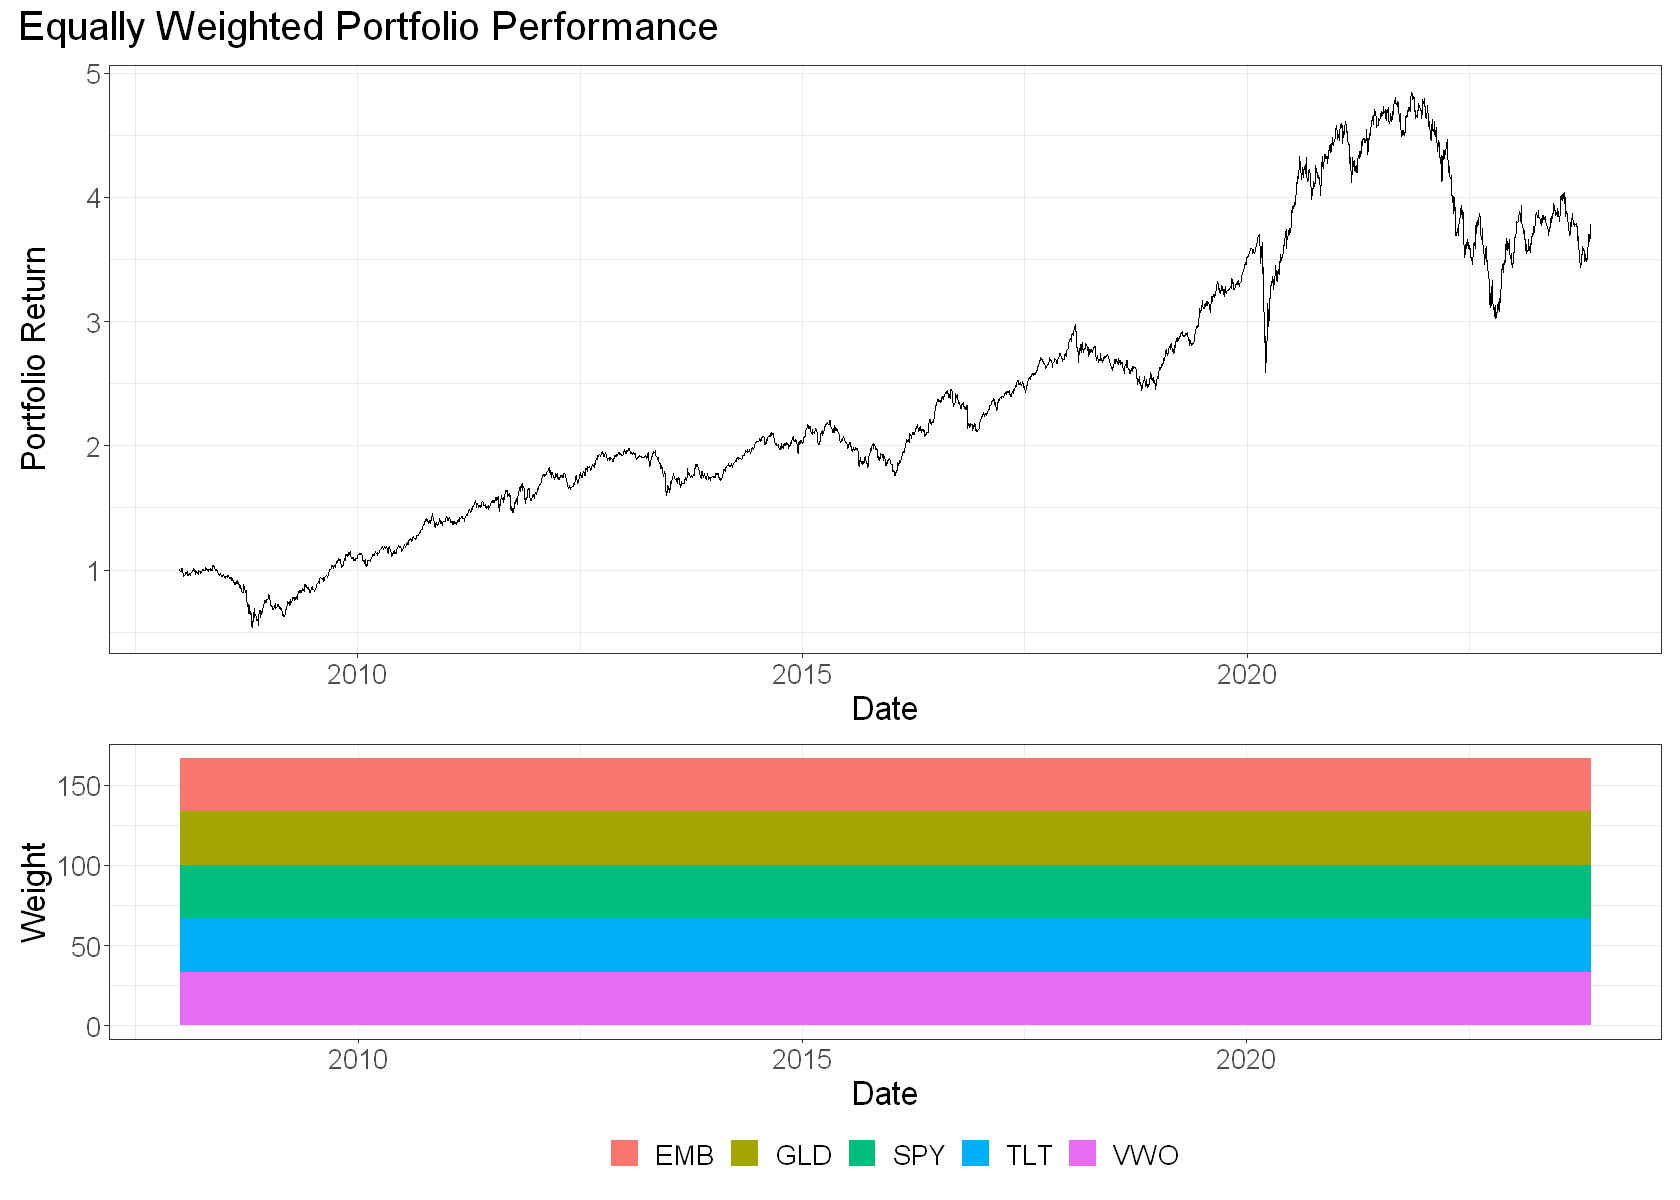

In [85]:
eq_wgts <- returns %>% 
  select(Date, Ticker, simple_return, fwd_simple_return) %>% 
  mutate(weight = 100/3)

show_performance(eq_wgts, title = "Equally Weighted Portfolio Performance")

The equal weight version makes no attempt to equalise the risk of the portfolio's component. It produces a slightly higher annual return (10%) at a much higher volatility (18%) for a much lower Sharpe (0.55).

It seems that you get the greatest improvement in risk adjusted returns simply from doing an ERC optimisation rather than equal weighting the portfolio components, and that a slightly better estimate of covariance gives a marginal improvement on that. 

## Summary

- The Equal Risk Portfolio seeks to maximally diversify the portfolios based on an estimate of the components' co-movements.
- This seems to significantly improve risk adjusted returns over the equal-weight case.
- Passing an exponentially weighted covariance estimate to the ERC optimiser seems to produce slightly better-performing weights than the rolling window covariance estimate. 

### Further work

It would be interesting to look at the effect of larger and smaller values of lambda on the performance of the ERC portfolio, both before and after costs. Smaller values of lambda will lead to more hyperactive rebalancing. That will probably lead to better pre-cost performance, but worse after-cost performance. It would be interesting to explore this trade off between responsiveness and turnover. 

Another example of using an exponentially weighted covariance estimate would be in a medium frequency convergence trade over a basket of related assets. In this example, you have a bunch of signals predicting expected returns, and you use a risk component to prevent getting too concentrated. Maybe we can do an example of this in a future post. 